In [4]:
import h5py
import os
import glob

from astropy import constants as const
from astropy import units as u

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from xray_binary_utils import stellar, compas_utils

from typing import Tuple
from collections import defaultdict

In [2]:
COMPAS_DIR_PATH: str = '/home/maya/Workspace/COMPAS'

In [3]:
# G: np.float64 = np.float64(6.67408 * 1e-11) # N * m2 / kg2
# SUNMASS: np.float64 = np.float64(1.989 * 1e30) # kg
# SECONDS_IN_YEAR: np.float64 = np.float64(31556926.) # s
# SUNRADIUS: np.float64 = np.float64(696340.) # / km
# SUNLUMINOSITY: np.float64 = np.float64(3.846 * 1e33) # erg / s
# c: np.float64 = np.float64(299792458.) # m / s

AU: np.float64 = np.float64(149597870700.) # m
HOURS_IN_YEAR: np.float64 = np.float64(8765.81277)

In [20]:
G: np.float64 = const.G
SUNMASS: np.float64 = const.M_sun.to(u.kg)

SUNRADIUS: np.float64 = const.R_sun.to(u.km)
SUNLUMINOSITY: np.float64 = const.L_sun.to('erg/s')
c: np.float64 = const.c.to('m/s')

AU_TO_M: np.float64 = const.au.to(u.m)
HOURS_IN_YEAR: np.float64 = u.year.to(u.hour)
SECONDS_IN_YEAR: np.float64 = u.year.to(u.second)

$T=2\pi\sqrt{\frac{a^3}{G(M_1+M_2)}}$

$T=\frac{2\pi a}{v_{orb}}$

$a=\frac{T v_{orb}}{2\pi}$

In [22]:
def period(a: np.float64,
           mass1: np.float64,
           mass2: np.float64) -> np.float64:
       """Calculates period for given semimajor axis using Kepler's law

       Args:
           a (np.float64): semimajor axis in AU
           mass1 (np.float64): first mass in sunmass
           mass2 (np.float64): second mass in sunmass

       Returns:
           [np.float64]: period in hours
       """
       mass1_si: np.float64 = mass1*SUNMASS
       mass2_si: np.float64 = mass2*SUNMASS
       
       return 2*np.pi*np.sqrt(np.power(a*AU, 3)/(G*(mass1_si+mass2_si)))/3600.

## Accretion disk luminosity

### Luminosity and accretion rate limits

Eddington's luminosity -- a theoretical limit of stellar luminosity assuming uniform flux. Can be approximated by the following formula, with M as the star's mass in sunmasses:

$L_{Edd}\ [L_\odot]=3.2\cdot10^4\cdot M\ [M_\odot]$

In [23]:
def eddington_luminosity(mass: np.float64) -> np.float64:
    """Eddington luminosity for the given mass

    Args:
        mass (np.float64): mass in sunmass

    Returns:
        np.float64: eddington luminosity in sun luminosities
    """
    return np.float64(3.2*1e4*mass)

Theoretical limit to accretion rate, given by the formula:

$\dot{M}_{Edd}=\frac{L_{Edd}}{\epsilon c^2}$

where $\epsilon=0.1$ in the thin disk approximation

In [24]:
def eddington_rate(ledd: np.float64,
                   epsilon: np.float64 = np.float64(.1)) -> np.float64:
    """Calculates the eddington rate for given eddington luminosity

    Args:
        ledd (np.float64): eddington luminosity in solar luminosities
        epsilon (np.float64, optional): [description]. Defaults to np.float64(.1).

    Returns:
        np.float64: eddington rate in sunmass/year
    """

    si_ledd: np.float64 = ledd * SUNLUMINOSITY
    si_medd: np.float64 = si_ledd/(epsilon * np.power(c, 2)) # kg / s

    return si_medd * SECONDS_IN_YEAR / SUNMASS

### LMXB x-ray luminosities

The formulas from luminosities were taken from ().

For LMXBs with BH accretors and their orbital period P:

$L_x=\eta_{bol}\epsilon\times min\Bigg[2\times L_{Edd}, 3\times L_{Edd}\Big(\frac{P}{10h}\Big)\Bigg]$

$\eta_{bol}$ -- factor converting from the bolometric luminosity to the x-ray luminosity. For BH we assume $\eta_{bol}=0.8$

$\epsilon$ -- conversion efficiency of gravitational binding energy to radiation. For BH we assume $\epsilon=0.5$

In [25]:
def bh_x_ray_luminosity(donor_mass: np.float64,
                        acceptor_mass: np.float64,
                        a: np.float64,
                        eta_bol: np.float64 = np.float64(0.8),
                        epsilon: np.float64 = np.float64(0.5)) -> np.float64:
    """X-ray luminosity for LMXB with BH accretor

    Args:
        donor_mass (np.float64): donor's mass in sunmass
        acceptor_mass (np.float64): acceptor's (BH's) mass in sunmass
        a (np.float64): semimajor axis in AU
        eta_bol (np.float64, optional): factor converting from the bolometric luminosity to x-ray. Defaults to np.float64(0.8).
        epsilon (np.float64, optional): conversion efficiency of gravitational binding energy to radiation. Defaults to np.float64(0.5).

    Returns:
        np.float64: x-ray luminosity in solar luminosities
    """
    ledd: np.float64 = eddington_luminosity(acceptor_mass) # sun luminosity
        
    p: np.float64 = period(a, donor_mass, acceptor_mass)
        
    return eta_bol * epsilon * np.min([2. * ledd, 3. * ledd * (p / 10)])

For LMXBs with NS accretors:

$L_x=\eta_{bol}\epsilon\times min\Bigg[2\times L_{Edd}, \frac{GM_a\dot{M}^2_{Edd}}{R_a\dot{M}_d}\Bigg

For NS, the factors are assumed to be as follows:

$\eta_{bol}=0.55$

$\epsilon=1.$

In [ ]:
'''
accretor_mass in sunmass
ledd - eddington luminosity in solar luminosities
accretor_radius in solar radii
donor_mass_rate in sunmass / yr

returns xray luminosity in solar luminosities
'''

In [26]:
def ns_x_ray_luminosity(accretor_mass: np.float64,
                        accretor_radius: np.float64,
                        donor_mass_rate: np.float64,
                        eta_bol: np.float64 = np.float64(0.55),
                        epsilon: np.float64 = np.float64(1.)) -> np.float64:
    """X-ray luminosity for LMXB with NS accretor

    Args:
        accretor_mass (np.float64): accretor's mass in sunmass
        accretor_radius (np.float64): accretor's radius in sunradius
        donor_mass_rate (np.float64): donor's mass loss rate
        eta_bol (np.float64, optional): factor converting the bolometric luminosity to x-ray luminosity. Defaults to np.float64(0.55).
        epsilon (np.float64, optional): conversion efficiency of gravitational binding energy to radiation. Defaults to np.float64(1.).

    Returns:
        np.float64: x-ray luminosity in solar luminosities
    """


    def critical_rate_luminosity(accretor_mass: np.float64,
                                 ledd: np.float64,
                                 accretor_radius: np.float64,
                                 donor_mass_rate: np.float64) -> np.float64:
        """[summary]

        Args:
            accretor_mass (np.float64): [description]
            ledd (np.float64): [description]
            accretor_radius (np.float64): [description]
            donor_mass_rate (np.float64): [description]

        Returns:
            np.float64: [description]
        """

        si_acc_mass: np.float64 = accretor_mass * SUNMASS
        si_acc_radius: np.float64 = accretor_radius * SUNRADIUS
        si_donor_mass_rate: np.float64 = donor_mass_rate * SUNMASS / SECONDS_IN_YEAR # kg / s

        medd: np.float64 = eddington_rate(ledd) # sunmass / yr
        si_medd: np.float64 = medd * SUNMASS / SECONDS_IN_YEAR # kg / s

        si_results = G * si_acc_mass * np.power(si_medd, 2) / (si_acc_radius * si_donor_mass_rate) # erg / s

        return si_results / SUNLUMINOSITY


    ledd: np.float64 = eddington_luminosity(accretor_mass)
    
    return eta_bol * epsilon * np.min([2. * ledd,
                                      critical_rate_luminosity(accretor_mass,
                                                               ledd,
                                                               accretor_radius,
                                                               donor_mass_rate)])

## Calculate luminosities

In [12]:
def is_accreting_onto_co(datum: np.array, donor_ind: int, acceptor_ind: int, ind: int) -> bool:
        return stellar.is_compact_object(datum[f'Stellar_Type({acceptor_ind})'][ind]) and \
            stellar.is_main_sequence(datum[f'Stellar_Type({donor_ind})'][ind]) and \
    datum[f'dmMT({acceptor_ind})'][ind] > 0.0

In [13]:
from typing import Optional

def accretion_data_to_numpy(output_file: h5py.File) -> Optional[np.array]:
    accretion_indices = np.concatenate([np.flatnonzero(output_file[f'dmMT(1)']),
                                        np.flatnonzero(output_file[f'dmMT(2)'])])
    
    result = []

    if len(accretion_indices) == 0:
        return None
    
    donor_mass = -1
    donor_type = -1
    acceptor_type = -1
    
    for ind in accretion_indices:
        
        luminosity = None
        
        # 2 is the acceptor
        if is_accreting_onto_co(output_file, 1, 2, ind):
            donor_mass = output_file['Mass(1)'][ind]
            donor_type = output_file['Stellar_Type(1)'][ind]
            acceptor_type = output_file['Stellar_Type(2)'][ind]
            
            accretion_rate: np.float64 = output_file['dmMT(2)'][ind]/(output_file['dT'][ind]*1e6)
                
#             luminosity = simple_luminosity(output_file['Mass(2)'][ind],
#                                        output_file['Radius(2)'][ind],
#                                        accretion_rate)

            # Black hole
            if donor_type == 14:
                luminosity: np.float64 = bh_x_ray_luminosity(donor_mass = donor_mass,
                                                             acceptor_mass = output_file['Mass(2)'][ind],
                                                             a = output_file['SemiMajorAxis'][ind])
            else:
                luminosity: np.float64 = ns_x_ray_luminosity(accretor_mass = output_file['Mass(2)'][ind],
                                                             accretor_radius = output_file['Radius(2)'][ind],
                                                             donor_mass_rate = accretion_rate)


        # 1 is the donor
        elif is_accreting_onto_co(output_file, 2, 1, ind):
            donor_mass = output_file['Mass(2)'][ind]
            donor_type = output_file['Stellar_Type(2)'][ind]
            acceptor_type = output_file['Stellar_Type(1)'][ind]
            
            luminosity = simple_luminosity(output_file['Mass(1)'][ind],
                                           output_file['Radius(1)'][ind],
                                           output_file['dmMT(1)'][ind]/(output_file['dT'][ind]*1e6))
            
            accretion_rate: np.float64 = output_file['dmMT(1)'][ind]/(output_file['dT'][ind]*1e6)

            # Black hole
            if donor_type == 14:
                luminosity: np.float64 = bh_x_ray_luminosity(donor_mass = donor_mass,
                                                             acceptor_mass = output_file['Mass(1)'][ind],
                                                             a = output_file['SemiMajorAxis'][ind])
            else:
                luminosity: np.float64 = ns_x_ray_luminosity(accretor_mass = output_file['Mass(1)'][ind],
                                                             accretor_radius = output_file['Radius(1)'][ind],
                                                             donor_mass_rate = accretion_rate)
            
        if luminosity:
            
            time = np.sum(output_file['dT'][:ind])
            
            result.append([donor_mass, donor_type, acceptor_type, luminosity,
                           time, time + output_file['dT'][ind]])
            
    return result

In [14]:
def process_all_files() -> pd.DataFrame:
    lmxb_array = []
    hmxb_array = []
    
    for f in glob.glob(f'../../COMPAS_Output/Detailed_Output/BSE_Detailed_Output_*.h5'):
        try:
            acc_data = accretion_data_to_numpy(h5py.File(f, 'r'))
            if len(acc_data) == 0:
                print(f'Removing {f}')
                os.remove(f)
                continue

            if acc_data[0][0]>=3.0:
                hmxb_array.extend(acc_data)
            else:
                lmxb_array.extend(acc_data)
                
        except Exception as e:
            print(f'{e} for {f}')
            continue
            
    lmxb = pd.DataFrame(lmxb_array,
                        columns=['donor_mass', 'donor_stellar_type', 'acceptor_stellar_type', 'luminosity',
                                 'start_time', 'end_time'])
    hmxb = pd.DataFrame(hmxb_array,
                        columns=['donor_mass', 'donor_stellar_type', 'acceptor_stellar_type', 'luminosity',
                                 'start_time', 'end_time'])
    
        
    return lmxb, hmxb

In [15]:
lmxb, hmxb = process_all_files()

Removing ../../COMPAS_Output/Detailed_Output/BSE_Detailed_Output_83970.h5
Removing ../../COMPAS_Output/Detailed_Output/BSE_Detailed_Output_166175.h5
Removing ../../COMPAS_Output/Detailed_Output/BSE_Detailed_Output_111441.h5
Removing ../../COMPAS_Output/Detailed_Output/BSE_Detailed_Output_191558.h5
Removing ../../COMPAS_Output/Detailed_Output/BSE_Detailed_Output_124037.h5
Removing ../../COMPAS_Output/Detailed_Output/BSE_Detailed_Output_29816.h5
Removing ../../COMPAS_Output/Detailed_Output/BSE_Detailed_Output_34784.h5
Removing ../../COMPAS_Output/Detailed_Output/BSE_Detailed_Output_41424.h5
Removing ../../COMPAS_Output/Detailed_Output/BSE_Detailed_Output_181935.h5
Removing ../../COMPAS_Output/Detailed_Output/BSE_Detailed_Output_193452.h5
Removing ../../COMPAS_Output/Detailed_Output/BSE_Detailed_Output_90773.h5
Removing ../../COMPAS_Output/Detailed_Output/BSE_Detailed_Output_21599.h5
Removing ../../COMPAS_Output/Detailed_Output/BSE_Detailed_Output_39513.h5
Removing ../../COMPAS_Output/Det

In [16]:
lmxb.head()

,donor_mass,donor_stellar_type,acceptor_stellar_type,luminosity,start_time,end_time
0,0.960642,7,13,44998.060221,87.258912,87.275547
1,0.960642,7,13,44998.060221,87.275547,88.436691
2,0.960642,7,13,44998.060221,87.258912,87.275547
3,0.960642,7,13,44998.060221,87.275547,88.436691
4,0.535525,7,13,44352.000000,233.864540,233.929578


In [17]:
lmxb['end_time'].max()

14642.031437075833

In [18]:
lmxb_ages = []
lmxb_luminosities = []

timestep = 10.

for time in np.arange(0.0, lmxb['end_time'].max(), timestep):
    lmxb_ages.append(time)
    lmxb_luminosities.append(lmxb[(lmxb['start_time']<=time+timestep) & (lmxb['end_time']>=time)].sum()['luminosity'])

In [20]:
hmxb_ages = []
hmxb_luminosities = []

timestep = 10.

for time in np.arange(0.0, hmxb['end_time'].max(), timestep):
    hmxb_ages.append(time)
    hmxb_luminosities.append(hmxb[(hmxb['start_time']<=time+timestep) & (hmxb['end_time']>=time)].sum()['luminosity'])

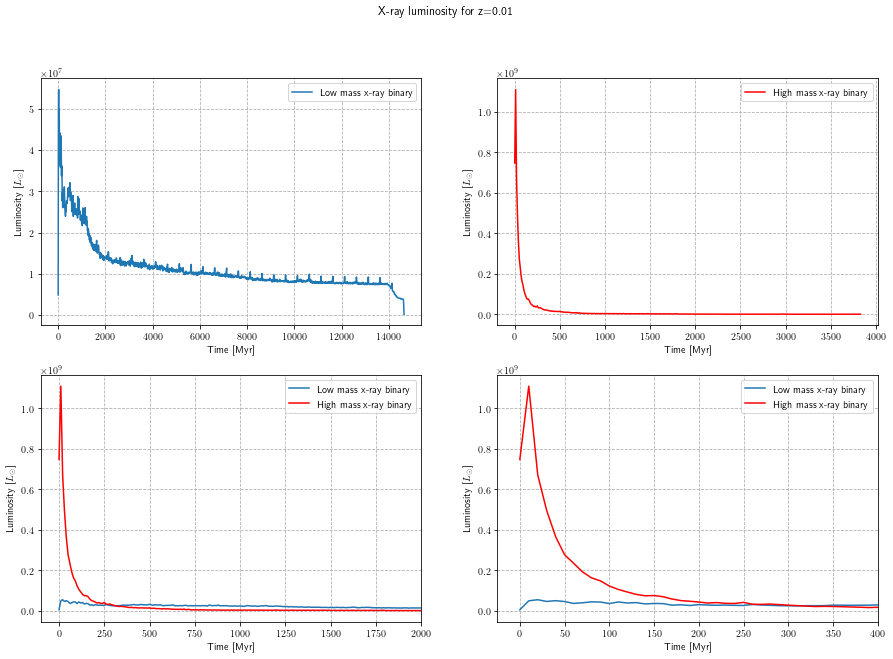

In [21]:
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

fig.suptitle('X-ray luminosity for z=0.01')

ax[0][0].plot(lmxb_ages[:], lmxb_luminosities[:], label = 'Low mass x-ray binary')
ax[0][0].grid(linestyle = '--')
ax[0][0].set_xlabel('Time [Myr]')
ax[0][0].set_ylabel('Luminosity [$L_\odot$]')
ax[0][0].legend()

ax[0][1].plot(hmxb_ages[:], hmxb_luminosities[:], c='red', label = 'High mass x-ray binary')
ax[0][1].grid(linestyle = '--')
ax[0][1].set_xlabel('Time [Myr]')
ax[0][1].set_ylabel('Luminosity [$L_\odot$]')
ax[0][1].legend()

ax[1][0].plot(lmxb_ages[:], lmxb_luminosities[:], label = 'Low mass x-ray binary')
ax[1][0].plot(hmxb_ages[:], hmxb_luminosities[:], c='red', label = 'High mass x-ray binary')
ax[1][0].set_xlim(-100, 2000)
ax[1][0].grid(linestyle = '--')
ax[1][0].set_xlabel('Time [Myr]')
ax[1][0].set_ylabel('Luminosity [$L_\odot$]')
ax[1][0].legend()

ax[1][1].plot(lmxb_ages[:], lmxb_luminosities[:], label = 'Low mass x-ray binary')
ax[1][1].plot(hmxb_ages[:], hmxb_luminosities[:], c='red', label = 'High mass x-ray binary')
ax[1][1].set_xlim(-25, 400)
ax[1][1].grid(linestyle = '--')
ax[1][1].set_xlabel('Time [Myr]')
ax[1][1].set_ylabel('Luminosity [$L_\odot$]')
ax[1][1].legend()